<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_1_Pytorch_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [52]:
import pandas as pd
from typing import Literal

In [53]:
def dataset_fn(train:Literal["train", "test"]):
  match train:
    case "train":
      df = pd.read_csv("/content/sample_data/california_housing_train.csv")
    case "test":
      df = pd.read_csv("/content/sample_data/california_housing_test.csv")

  return df.drop("median_house_value", axis=1), df["median_house_value"].copy()

In [54]:
x, y = dataset_fn(train="train")
y.head(3)

,median_house_value
0,66900.0
1,80100.0
2,85700.0


In [55]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


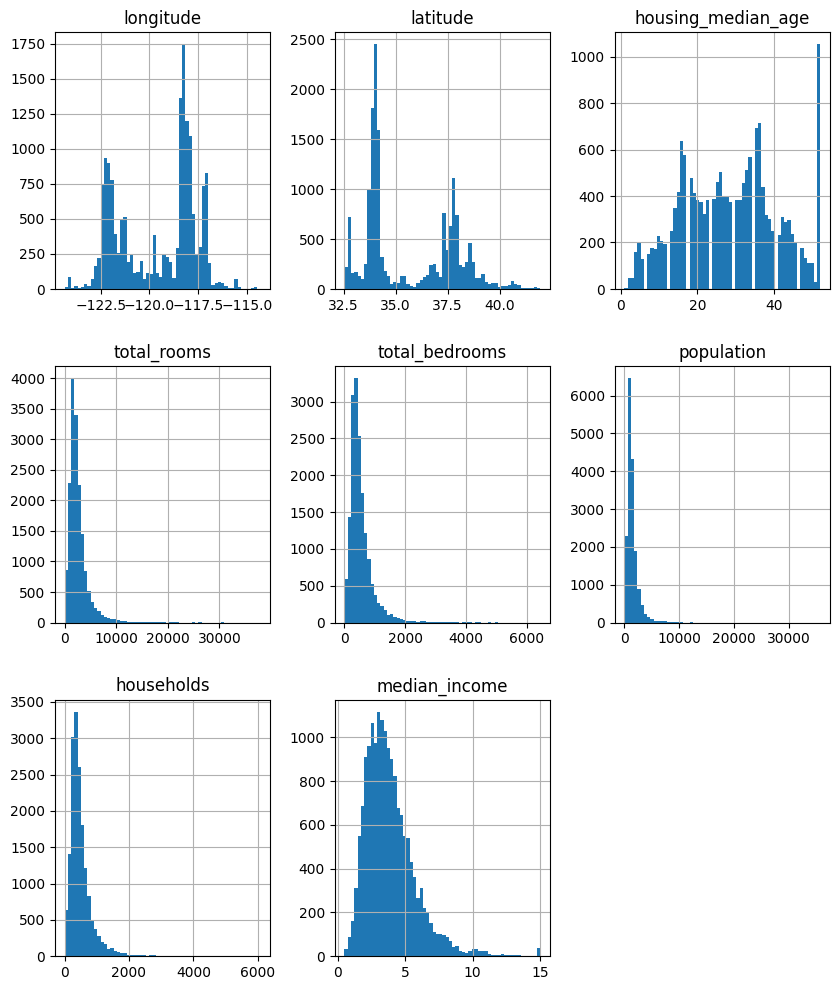

In [56]:
x.hist(figsize=(10, 12), bins=60);

# Dataset

## Splitting into Training and Testing Dataset

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [58]:
x_scaler, y_scaler = StandardScaler(), StandardScaler()

In [59]:
x_scaler.fit(x.to_numpy())
y_scaler.fit(y.to_numpy().reshape(-1, 1))

StandardScaler()

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [61]:
print(f"Training Sample --> {len(x_train)}")
print(f"Testing Sample --> {len(x_test)}")

Training Sample --> 11900
Testing Sample --> 5100


## Dataset and DataLoader

In [62]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [63]:
class CaliforniaDataset(Dataset):
  def __init__(self, x, y, x_scaler=x_scaler, y_scaler=y_scaler):
    self.x = x_scaler.transform(x.to_numpy()).astype(np.float32)
    self.y = y_scaler.transform(y.to_numpy().reshape(-1, 1)).astype(np.float32)
    self.n_samples = len(self.x)

  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return x, y

  def __len__(self):
    return self.n_samples

In [64]:
train_ds = CaliforniaDataset(
    x=x_train,
    y=y_train
    )

In [65]:
test_ds = CaliforniaDataset(
    x=x_test,
    y=y_test
    )

In [66]:
train_dataloader = DataLoader(dataset=train_ds, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=10, shuffle=True)

# Defining Model Architecture

In [67]:
import torch.nn as nn

In [68]:
class CaliforniaModel(nn.Module):
  def __init__(self, skeleton:list):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], 1))
    self.model = nn.Sequential(*layer_list)

  def forward(self, x):
    return self.model(x)

In [69]:
model = CaliforniaModel(skeleton=[8, 300, 200, 100, 50, 20])

In [70]:
lr = 1e-4
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [71]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=30,
    T_mult=1,
    eta_min=1e-6
)

# Training Loop

In [72]:
from tqdm import trange
import numpy as np

In [73]:
def train_step(model, x, y, criterion, optimizer):
  x, y = x.cpu(), y.cpu()

  optimizer.zero_grad()
  y_hat = model(x)
  loss = criterion(y_hat, y)
  loss.backward()
  optimizer.step()
  lr = optimizer.param_groups[0]["lr"]
  return loss.item(), lr

In [74]:
def test_step(model, x, y, criterion):
  x, y = x.cpu(), y.cpu()

  with torch.no_grad():
    y_hat = model(x)
    loss = criterion(y_hat, y)

  return loss.item()

In [75]:
def fit(model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        criterion=criterion, optimizer=optimizer,
        scheduler=scheduler, epochs=30):

  df = pd.DataFrame(np.empty([epochs, 4]),
                    index = np.arange(epochs),
                    columns = ["Training Loss", "Testing Loss", "lr", "Epochs"])

  current_test_loss = float("inf")

  for epoch in range(epochs):

    print(f"Epoch {epoch+1}")
    # Training
    model.train()
    progress_bar = trange(len(train_dataloader), desc="Training")

    train_loss = []

    for batch_idx, (x, y) in enumerate(train_dataloader):
        loss, lr = train_step(model, x, y, criterion, optimizer)
        scheduler.step(epoch + batch_idx / len(train_dataloader))

        progress_bar.set_description("Training Loss=%.9f" % loss)
        progress_bar.set_postfix({"lr": lr})
        progress_bar.update(1)
        train_loss.append(loss)
    progress_bar.close()
    mean_train_loss = np.mean(train_loss)


    # Testing
    model.eval()
    test_losses = []

    progress_bar = trange(len(test_dataloader), desc="Testing")

    for batch_idx, (x, y) in enumerate(test_dataloader):
      loss = test_step(model, x, y, criterion)
      test_losses.append(loss)
      progress_bar.set_description("Testing Loss=%.9f" % loss)
      progress_bar.update(1)

    progress_bar.close()
    mean_test_loss = np.mean(test_losses)

    if mean_test_loss < current_test_loss:
      current_test_loss = mean_test_loss
      print(current_test_loss)
      torch.save(model.state_dict(), "Model_state.pth")
      print("Saving Training State....!!!!!")

    scheduler.step()

    df.iloc[epoch, 0] = mean_train_loss
    df.iloc[epoch, 1] = mean_test_loss
    df.iloc[epoch, 2] = optimizer.param_groups[0]["lr"]
    df.iloc[epoch, 3] = epoch + 1

    print(f"Epoch {epoch+1}: Train Loss={mean_train_loss:.6f}, Test Loss={mean_test_loss:.6f}")

  return df

# Fitting Model

In [76]:
model = model.cpu()

In [ ]:
df = fit(model=model)

Epoch 1


Testing Loss=0.276456684: 100%|██████████| 510/510 [00:01<00:00, 383.96it/s]


0.16959271982823518
Saving Training State....!!!!!
Epoch 1: Train Loss=0.213188, Test Loss=0.169593
Epoch 2


Testing Loss=0.336569756: 100%|██████████| 510/510 [00:01<00:00, 361.76it/s]


0.15126726312891525
Saving Training State....!!!!!
Epoch 2: Train Loss=0.181769, Test Loss=0.151267
Epoch 3


Testing Loss=0.043591410: 100%|██████████| 510/510 [00:01<00:00, 307.98it/s]


0.1507106819683138
Saving Training State....!!!!!
Epoch 3: Train Loss=0.176482, Test Loss=0.150711
Epoch 4


Testing Loss=0.106412292: 100%|██████████| 510/510 [00:01<00:00, 331.30it/s]


Epoch 4: Train Loss=0.169116, Test Loss=0.155388
Epoch 5


Testing Loss=0.032358915: 100%|██████████| 510/510 [00:01<00:00, 375.06it/s]


0.15015314984518816
Saving Training State....!!!!!
Epoch 5: Train Loss=0.168211, Test Loss=0.150153
Epoch 6


Testing Loss=0.138068348: 100%|██████████| 510/510 [00:01<00:00, 358.23it/s]


0.14728323566709078
Saving Training State....!!!!!
Epoch 6: Train Loss=0.161797, Test Loss=0.147283
Epoch 7


Testing Loss=0.075056605: 100%|██████████| 510/510 [00:01<00:00, 381.17it/s]


Epoch 7: Train Loss=0.159598, Test Loss=0.149107
Epoch 8


Testing Loss=0.206450701: 100%|██████████| 510/510 [00:01<00:00, 363.19it/s]


Epoch 8: Train Loss=0.159944, Test Loss=0.148663
Epoch 9


Testing Loss=0.143336803: 100%|██████████| 510/510 [00:01<00:00, 364.39it/s]


0.14599610433420715
Saving Training State....!!!!!
Epoch 9: Train Loss=0.161716, Test Loss=0.145996
Epoch 10


Testing Loss=0.096851118: 100%|██████████| 510/510 [00:01<00:00, 359.60it/s]


0.13477861426003715
Saving Training State....!!!!!
Epoch 10: Train Loss=0.157994, Test Loss=0.134779
Epoch 11


Testing Loss=0.108677305: 100%|██████████| 510/510 [00:01<00:00, 318.18it/s]


Epoch 11: Train Loss=0.154850, Test Loss=0.174140
Epoch 12


Testing Loss=0.198441714: 100%|██████████| 510/510 [00:01<00:00, 334.61it/s]


0.13034319311526477
Saving Training State....!!!!!
Epoch 12: Train Loss=0.151231, Test Loss=0.130343
Epoch 13


Testing Loss=0.206081390: 100%|██████████| 510/510 [00:01<00:00, 363.53it/s]


Epoch 13: Train Loss=0.152011, Test Loss=0.138402
Epoch 14


Testing Loss=0.204908878: 100%|██████████| 510/510 [00:01<00:00, 373.55it/s]


Epoch 14: Train Loss=0.149899, Test Loss=0.145484
Epoch 15


Testing Loss=0.132975757: 100%|██████████| 510/510 [00:01<00:00, 356.85it/s]


Epoch 15: Train Loss=0.151278, Test Loss=0.131558
Epoch 16


Testing Loss=0.102592729: 100%|██████████| 510/510 [00:01<00:00, 375.26it/s]


0.12908155166671847
Saving Training State....!!!!!
Epoch 16: Train Loss=0.149189, Test Loss=0.129082
Epoch 17


Testing Loss=0.079217017: 100%|██████████| 510/510 [00:01<00:00, 361.63it/s]


Epoch 17: Train Loss=0.149420, Test Loss=0.132306
Epoch 18


Testing Loss=0.219958141: 100%|██████████| 510/510 [00:01<00:00, 339.13it/s]


Epoch 18: Train Loss=0.148134, Test Loss=0.133332
Epoch 19


Testing Loss=0.071160153: 100%|██████████| 510/510 [00:01<00:00, 343.80it/s]


0.1280695294796982
Saving Training State....!!!!!
Epoch 19: Train Loss=0.145455, Test Loss=0.128070
Epoch 20


Testing Loss=0.070876673: 100%|██████████| 510/510 [00:01<00:00, 353.90it/s]


Epoch 20: Train Loss=0.145671, Test Loss=0.130549
Epoch 21


Testing Loss=0.118526280: 100%|██████████| 510/510 [00:01<00:00, 357.13it/s]


0.1236198478579229
Saving Training State....!!!!!
Epoch 21: Train Loss=0.147755, Test Loss=0.123620
Epoch 22


Testing Loss=0.199434787:  58%|█████▊    | 296/510 [00:00<00:00, 383.68it/s]

## Model Training Inferences

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(df["Epochs"],df["Training Loss"], "--", markersize=3, label="Training Loss")
plt.plot(df["Epochs"],df["Testing Loss"], label="Testing Loss")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Model Inference

In [ ]:
def test_model(state_dict_path, criterion):
  x,y = dataset_fn(train="test")
  ds = CaliforniaDataset(x, y)
  dataloader = DataLoader(ds, batch_size=10, shuffle=False)

  test_losses = []

  model.load_state_dict(state_dict=torch.load(state_dict_path))
  print("Model Loaded....")

  model.eval()
  progress_bar = trange(len(dataloader), desc="Model Eval")

  for batch, (x,y) in enumerate(dataloader):
    loss = test_step(model, x, y, criterion)
    test_losses.append(loss)
    progress_bar.set_description("Testing Loss=%.9f" % loss)
    progress_bar.update(1)

  progress_bar.close()
  mean_test_loss = np.mean(test_losses)

  return mean_test_loss

In [80]:
mean_loss = test_model(state_dict_path="/content/Model_state.pth", criterion=nn.MSELoss())
corrected_mean_loss = y_scaler.inverse_transform(mean_loss.reshape(-1, 1))

RMSE = np.sqrt(corrected_mean_loss)

Model Loaded....


Testing Loss=0.308022171: 100%|██████████| 300/300 [00:00<00:00, 364.56it/s]


In [81]:
print(f"The final Root Mean Square Loss is ${RMSE[0, 0]}")

The final Root Mean Square Loss is $488.70506021546413
